In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib widget
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers.legacy import Adagrad, SGD, Adam
import cv2
import visualkeras
from PIL import ImageFont


In [2]:
def open_data(path):

    # Path to the folder where HDF5 files are saved
    input_folder = path#

    # Initialize an empty list to store image data
    image_data_list = []
    cloud_map_data_list = []

    # Iterate over files in the folder
    for filename in os.listdir(input_folder):
        # Check if the file is an HDF5 file
        if filename.endswith(".h5"):
            input_path = os.path.join(input_folder, filename)

            with h5py.File(input_path, 'r') as file:
                # Check if 'image' dataset exists in the file
                if 'image' in file:
                    img_data = file['image'][:]
                    cp_data = file['label_map'][:]

                    img_max_val = np.max((np.abs(img_data)))
                    img_data = img_data/40

                    image_data_list.append(img_data)
                    cloud_map_data_list.append(cp_data)
                else:
                    print(f"Dataset 'image' not found in file: {input_path}")

    # Convert the list of image data to a numpy array
    image_data = np.array(image_data_list)
    image_data = np.expand_dims(image_data, axis=-1)

    cloud_map_data = np.array(cloud_map_data_list)

    # Display the shape of the resulting array
    print(f"Shape of the image data array: {image_data.shape}")
    print(f"Shape of the cloud map data array: {cloud_map_data.shape}")

    return image_data, cloud_map_data

def cut_images(image_data, section_size, overlap=0.5):
    cut_frames = []

    for image in image_data:
        # Calculate the number of sections along each dimension
        num_rows = (image.shape[0] - section_size) // int(section_size * (1 - overlap)) + 1
        num_cols = (image.shape[1] - section_size) // int(section_size * (1 - overlap)) + 1

        # Cut the image into sections with 50% overlap
        for i in range(num_rows):
            for j in range(num_cols):
                row_start = i * int(section_size * (1 - overlap))
                row_end = row_start + section_size
                col_start = j * int(section_size * (1 - overlap))
                col_end = col_start + section_size

                # Append the cut section to the list
                cut_frames.append(image[row_start:row_end, col_start:col_end, :])
    
    print(f"Shape of the new data array: {(np.array(cut_frames).shape)}")

    return np.array(cut_frames)

def cut_label(image_data, section_size, overlap=0.5):
    cut_frames = []

    for image in image_data:
        # Calculate the number of sections along each dimension
        num_rows = (image.shape[0] - section_size) // int(section_size * (1 - overlap)) + 1
        num_cols = (image.shape[1] - section_size) // int(section_size * (1 - overlap)) + 1

        # Cut the image into sections with 50% overlap
        for i in range(num_rows):
            for j in range(num_cols):
                row_start = i * int(section_size * (1 - overlap))
                row_end = row_start + section_size
                col_start = j * int(section_size * (1 - overlap))
                col_end = col_start + section_size

                # Append the cut section to the list
                cut_frames.append(image[row_start:row_end, col_start:col_end, :])
    
    print(f"Shape of the new data array: {(np.array(cut_frames).shape)}")

    return np.array(cut_frames)


In [3]:
image_data, cloud_map_data = open_data('/Users/lukas/Dokumente/Uni/SSI/CNN_data/cloudfirewater/')

Shape of the image data array: (38, 320, 256, 1)
Shape of the cloud map data array: (38, 320, 256, 4)


In [403]:
class_counts = np.zeros(4)
total_counts = (cloud_map_data.size/4)//1#.shape[0]*cloud_map_data.shape[1]*cloud_map_data.shape[2]

# Sum the values in the last dimension to get the count for each class
class_counts = np.sum(cloud_map_data, axis=(0, 1, 2))
class_counts_inv = total_counts/np.sum(cloud_map_data, axis=(0, 1, 2))
class_counts_inv = (class_counts_inv/np.min(class_counts_inv)).astype(int)

class_weight = {
    0: 1,  # no_cloud
    1: 1.5,  # cloud
    2: 2,  # water
    3: 20  # fire
}

# Display the count for each class
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count}")

print(f"Total: {total_counts} pixels")

Class 0: 2100611.0
Class 1: 711263.0
Class 2: 300880.0
Class 3: 206.0
Total: 3112960.0 pixels


In [753]:
class_weight = {
    0: 1,  # no_cloud
    1: 1.5,  # cloud
    2: 2,  # water
    3: 10  # fire
}

In [536]:
### delete fire pixels in the label data ###
cloud_water_map_data = np.delete(cloud_map_data, 3, axis=-1)
cloud_water_map_data.shape

(38, 320, 256, 3)

In [244]:

fire_list = [index for index, img in enumerate(num_cloud_map_data) if np.any(img == 2)]
fire_images = image_data[fire_list]
fire_labels = cloud_map_data[fire_list]
indices_list, fire_images.shape, fire_labels.shape

([3, 4, 5, 13, 14, 17, 18, 19, 21, 23, 25, 33, 34, 39],
 (14, 320, 256, 1),
 (14, 320, 256, 3))

In [242]:

# Define the downsampling factor, for example, let's downsample by a factor of 2
downsampling_factor = 2

# Assuming image_data has the shape (XX, a, b, 1)
num_frames, height, width, channels = image_data.shape

# Initialize an array to store the resized frames
resized_frames = np.zeros((num_frames, height // downsampling_factor, width // downsampling_factor, channels))
resized_masks = np.zeros((num_frames, height // downsampling_factor, width // downsampling_factor, channels))


# Resize each frame and store in the new array
for i in range(num_frames):
    resized_frames[i, :, :, 0] = cv2.resize(image_data[i, :, :, 0], 
                                            (width // downsampling_factor, height // downsampling_factor), 
                                            interpolation=cv2.INTER_AREA)
    resized_masks[i, :, :, 0] = cv2.resize(cloud_map_data[i, :, :, 0], 
                                            (width // downsampling_factor, height // downsampling_factor), 
                                            interpolation=cv2.INTER_AREA)
    resized_masks[i, :, :, 0][resized_masks[i, :, :, 0]>0] = 1


In [162]:
section_size = 128
cut_frames = cut_images(image_data, section_size=section_size, overlap=0.25)
cut_labels = cut_label(cloud_map_data, section_size=section_size, overlap=0.25)
input_shape=(section_size, section_size, 1)

Shape of the new data array: (228, 128, 128, 1)
Shape of the new data array: (228, 128, 128, 4)


In [329]:

section_size = 128
cut_fire_frames = cut_images(fire_images, section_size=section_size, overlap=0.25)
cut_fire_labels = cut_label(fire_labels, section_size=section_size, overlap=0.25)
input_shape=(section_size, section_size, 1)

NameError: name 'fire_images' is not defined

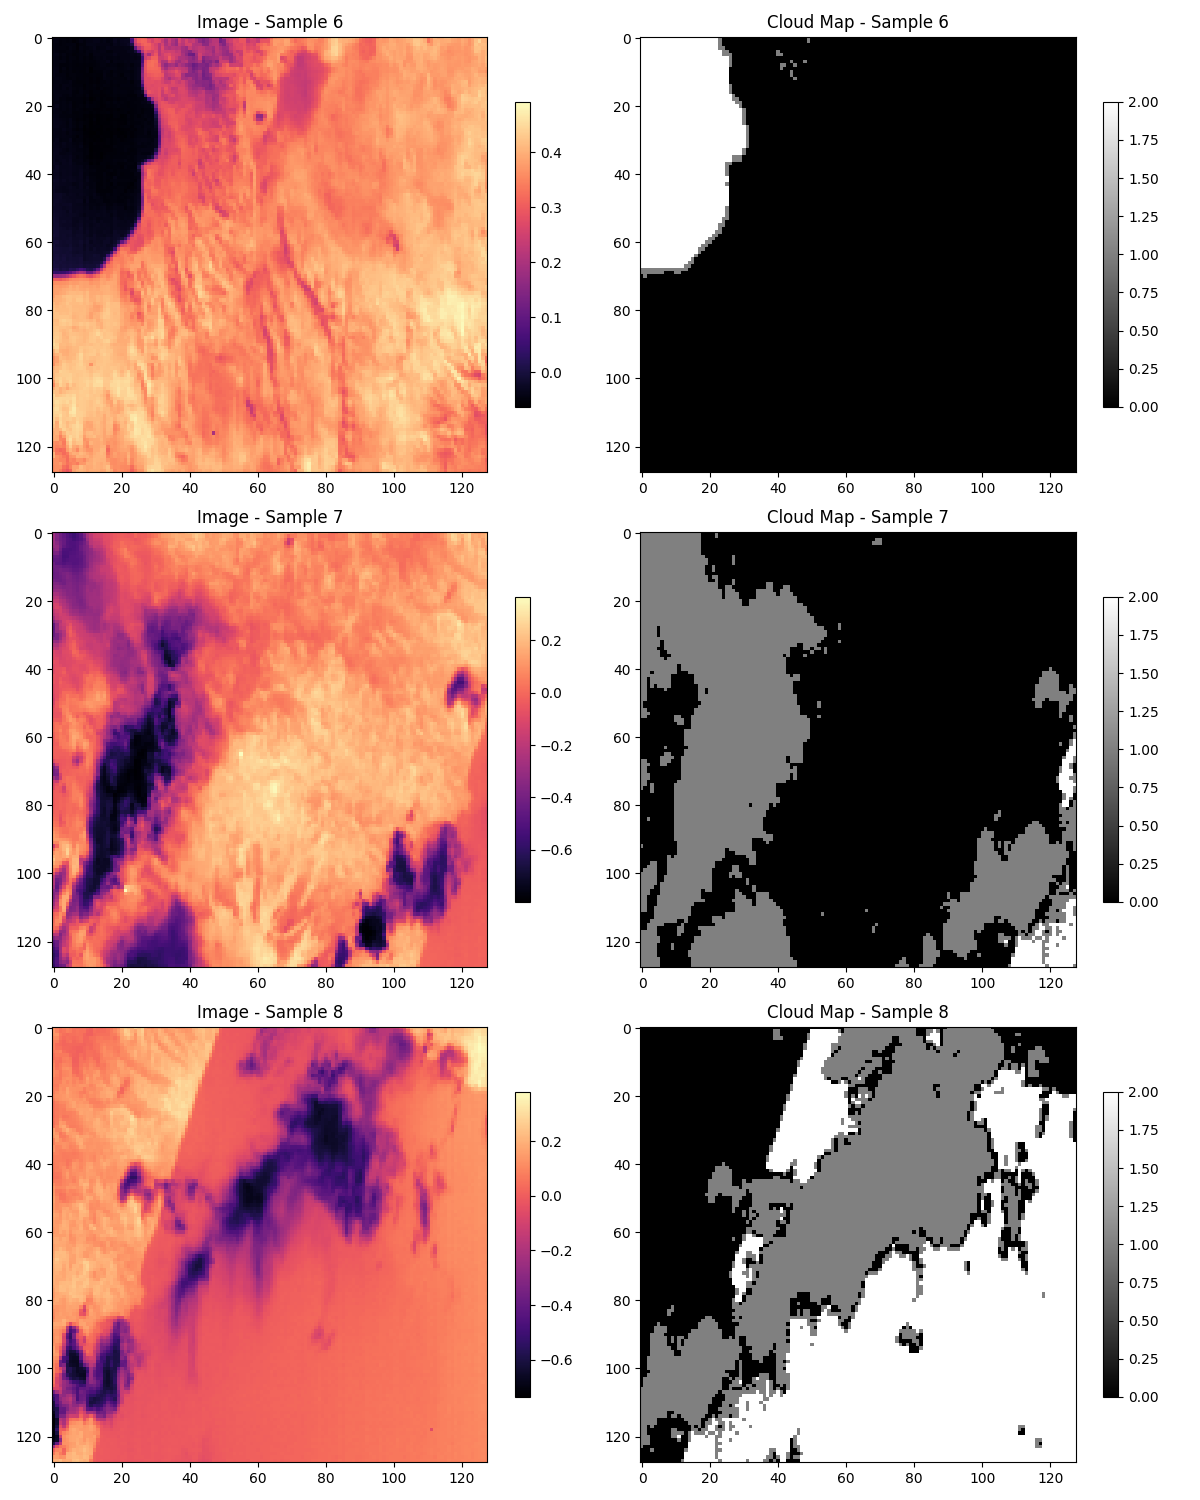

In [163]:
num_samples = 3
i_offset = 5

plt.figure(figsize=(12, 15))

# Plot the images and their corresponding cloud maps
for i in range(num_samples):
    # Plot the first image
    plt.subplot(num_samples, 2, i*2 + 1)
    plt.imshow(cut_frames[i + i_offset, :, :], cmap='magma')
    plt.title(f'Image - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

    combined_map = np.argmax(cut_labels[i + i_offset, :, :, :], axis=-1)

    # Plot the corresponding cloud map
    plt.subplot(num_samples, 2, i*2 + 2)
    plt.imshow(combined_map, cmap='binary_r')
    plt.title(f'Cloud Map - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

plt.tight_layout()
plt.show()

In [695]:
image_train, image_test, cloud_train, cloud_test = train_test_split(cut_frames, cut_labels, test_size=0.2, random_state=999)

In [34]:
(image_train.shape[1],image_train.shape[2] , 1)

(320, 256, 1)

In [72]:
image_train, image_test, cloud_train, cloud_test = train_test_split(image_data, cloud_map_data, test_size=0.2, random_state=41)
input_shape = (image_train.shape[1],image_train.shape[2] , 1)

In [250]:

fire_image_train, fire_image_test, fire_label_train, fire_label_test = train_test_split(cut_fire_frames, cut_fire_labels, test_size=0.2, random_state=42)

In [430]:
model = models.Sequential()

# Encoder
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Output layer
model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))

#optimizer = Adam(learning_rate=0.001)
#optimizer = Adagrad(learning_rate=0.001)
optimizer = SGD(learning_rate=0.005)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_103 (B  (None, 128, 128, 64)      256       
 atchNormalization)                                              
                                                                 
 conv2d_133 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_104 (B  (None, 128, 128, 64)      256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                      

In [164]:
# Encoder
inputs = layers.Input(shape=input_shape)
conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
#batch1 = layers.BatchNormalization()(conv1)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(conv1)
batch2 = layers.BatchNormalization()(conv2)
pool1 = layers.MaxPooling2D((2, 2))(batch2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool1)
batch3 = layers.BatchNormalization()(conv3)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
batch4 = layers.BatchNormalization()(conv4)
pool2 = layers.MaxPooling2D((2, 2))(batch4)

conv5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool2)
batch5 = layers.BatchNormalization()(conv5)
conv6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)

# Decoder
up7 = layers.UpSampling2D(size=(2, 2))(conv6)
concat7 = layers.Concatenate()([up7, conv4])
batch7 = layers.BatchNormalization()(concat7)
conv7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch7)
batch8 = layers.BatchNormalization()(conv7)
conv8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch8)
dropout8 = layers.Dropout(0.1)(conv8)

up9 = layers.UpSampling2D(size=(2, 2))(dropout8)
concat9 = layers.Concatenate()([up9, conv2])
batch9 = layers.BatchNormalization()(concat9)
conv9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch9)
batch10 = layers.BatchNormalization()(conv9)
conv10 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch10)
dropout10 = layers.Dropout(0.2)(conv10)

# Output layer
output = layers.Conv2D(4, (1, 1), activation='softmax')(dropout10)

# Create the model
model = models.Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = SGD(learning_rate=0.015)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_67 (Conv2D)          (None, 128, 128, 32)         320       ['input_8[0][0]']             
                                                                                                  
 conv2d_68 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_67[0][0]']           
                                                                                                  
 batch_normalization_48 (Ba  (None, 128, 128, 32)         128       ['conv2d_68[0][0]']           
 tchNormalization)                                                                          

In [694]:
# Encoder
inputs = layers.Input(shape=input_shape)
conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
#batch1 = layers.BatchNormalization()(conv1)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(conv1)
batch2 = layers.BatchNormalization()(conv2)
pool1 = layers.MaxPooling2D((2, 2))(batch2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool1)
batch3 = layers.BatchNormalization()(conv3)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
batch4 = layers.BatchNormalization()(conv4)
pool2 = layers.MaxPooling2D((2, 2))(batch4)

conv5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool2)
batch5 = layers.BatchNormalization()(conv5)
conv6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)

# Decoder
up7 = layers.UpSampling2D(size=(2, 2))(conv6)
concat7 = layers.Concatenate()([up7, conv4])
batch7 = layers.BatchNormalization()(concat7)
conv7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch7)
batch8 = layers.BatchNormalization()(conv7)
conv8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch8)
dropout8 = layers.Dropout(0.1)(conv8)

up9 = layers.UpSampling2D(size=(2, 2))(dropout8)
concat9 = layers.Concatenate()([up9, conv2])
batch9 = layers.BatchNormalization()(concat9)
conv9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch9)
batch10 = layers.BatchNormalization()(conv9)
conv10 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch10)
dropout10 = layers.Dropout(0.2)(conv10)

# Output layer
output = layers.Conv2D(4, (1, 1), activation='softmax')(dropout10)

# Create the model
model = models.Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_100 (Conv2D)         (None, 128, 128, 32)         320       ['input_11[0][0]']            
                                                                                                  
 conv2d_101 (Conv2D)         (None, 128, 128, 32)         9248      ['conv2d_100[0][0]']          
                                                                                                  
 batch_normalization_72 (Ba  (None, 128, 128, 32)         128       ['conv2d_101[0][0]']          
 tchNormalization)                                                                          

In [561]:

# Encoder
inputs = layers.Input(shape=input_shape)
conv1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
batch1 = layers.BatchNormalization()(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch1)
batch2 = layers.BatchNormalization()(conv2)
pool1 = layers.MaxPooling2D((2, 2))(batch2)

conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool1)
batch3 = layers.BatchNormalization()(conv3)
conv4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
batch4 = layers.BatchNormalization()(conv4)
pool2 = layers.MaxPooling2D((2, 2))(batch4)

conv5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool2)
batch41 = layers.BatchNormalization()(conv5)
conv6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch41)
batch42 = layers.BatchNormalization()(conv6)
pool3 = layers.MaxPooling2D((2, 2))(batch42)

bottleneck5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool3)
batch5 = layers.BatchNormalization()(bottleneck5)
bottleneck6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)

# Decoder
up7 = layers.UpSampling2D(size=(2, 2))(bottleneck6)
concat7 = layers.Concatenate()([up7, conv6])
batch7 = layers.BatchNormalization()(concat7)
conv7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch7)
batch8 = layers.BatchNormalization()(conv7)
conv8 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch8)
dropout8 = layers.Dropout(0.1)(conv8)

up9 = layers.UpSampling2D(size=(2, 2))(dropout8)
concat9 = layers.Concatenate()([up9, conv4])
batch9 = layers.BatchNormalization()(concat9)
conv9 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch9)
batch10 = layers.BatchNormalization()(conv9)
conv10 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch10)
dropout10 = layers.Dropout(0.2)(conv10)

up11 = layers.UpSampling2D(size=(2, 2))(dropout10)
concat11 = layers.Concatenate()([up11, conv2])
batch11 = layers.BatchNormalization()(concat11)
conv11 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch11)
batch12 = layers.BatchNormalization()(conv11)
conv12 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch12)
dropout12 = layers.Dropout(0.2)(conv12)

# Output layer
output = layers.Conv2D(1, (1, 1), activation='sigmoid')(dropout12)

# Create the model
model = models.Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = SGD(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_187 (Conv2D)         (None, 128, 128, 64)         640       ['input_14[0][0]']            
                                                                                                  
 batch_normalization_148 (B  (None, 128, 128, 64)         256       ['conv2d_187[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_188 (Conv2D)         (None, 128, 128, 64)         36928     ['batch_normalization_1

In [697]:
datagen = ImageDataGenerator(
    rotation_range=10,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    #zoom_range=0.2,
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Randomly flip images vertically
    fill_mode='reflect'
)

batch_size = 10
steps_per_epoch = len(image_train) // batch_size

# Fit the data generator to the training data (assuming you have a variable named 'train_images')
datagen.fit(image_train)
gen_seed = 42

# Create a generator for both the input images and the ground truth masks
image_generator = datagen.flow(image_train, batch_size=batch_size, seed=gen_seed)
mask_generator = datagen.flow(cloud_train, batch_size=batch_size, seed=gen_seed)

# Combine the generators into one using zip
train_generator = zip(image_generator, mask_generator)

#aug_train_images = datagen.flow(image_train, cloud_train, batch_size=batch_size)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-4)


# Define a ModelCheckpoint callback to save the model at each epoch
checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_best_only=False)


In [9]:
def plot_history(history):
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    #plt.yticks(np.arange(0.8,1.01,0.01))
    #plt.ylim(0.89,1)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(top=1)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0)
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [696]:
history = model.fit(image_train, cloud_train, batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=200, class_weight=class_weight, validation_data=(image_test, cloud_test))

Epoch 1/200
18/18 [==============================] - 10s 530ms/step - loss: 1.0161 - accuracy: 0.4861 - val_loss: 1.0839 - val_accuracy: 0.7813
Epoch 2/200
18/18 [==============================] - 9s 525ms/step - loss: 0.6123 - accuracy: 0.7230 - val_loss: 0.8336 - val_accuracy: 0.8228
Epoch 3/200
18/18 [==============================] - 9s 493ms/step - loss: 0.5152 - accuracy: 0.7792 - val_loss: 0.6955 - val_accuracy: 0.8439
Epoch 4/200
18/18 [==============================] - 9s 494ms/step - loss: 0.4632 - accuracy: 0.8096 - val_loss: 0.5899 - val_accuracy: 0.8449
Epoch 5/200
18/18 [==============================] - 9s 492ms/step - loss: 0.4199 - accuracy: 0.8316 - val_loss: 0.5513 - val_accuracy: 0.8467
Epoch 6/200
18/18 [==============================] - 9s 499ms/step - loss: 0.5227 - accuracy: 0.7952 - val_loss: 0.5412 - val_accuracy: 0.8455
Epoch 7/200
18/18 [==============================] - 9s 496ms/step - loss: 0.4085 - accuracy: 0.8314 - val_loss: 0.4958 - val_accuracy: 0.847

In [755]:
history_train = model.fit(image_train, cloud_train, 
                            batch_size=batch_size, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=50, 
                            class_weight=class_weight, 
                            validation_data=(image_test, cloud_test)
                            #, callbacks=[reduce_lr]
                            )

# Append the values from history to history_main
history.history['loss'].extend(history_train.history['loss'])
history.history['val_loss'].extend(history_train.history['val_loss'])
history.history['accuracy'].extend(history_train.history['accuracy'])
history.history['val_accuracy'].extend(history_train.history['val_accuracy'])

Epoch 1/50
18/18 [==============================] - 10s 535ms/step - loss: 0.1731 - accuracy: 0.9500 - val_loss: 0.1874 - val_accuracy: 0.9354
Epoch 2/50
18/18 [==============================] - 9s 524ms/step - loss: 0.1848 - accuracy: 0.9461 - val_loss: 0.1942 - val_accuracy: 0.9372
Epoch 3/50
18/18 [==============================] - 9s 501ms/step - loss: 0.1777 - accuracy: 0.9484 - val_loss: 0.1906 - val_accuracy: 0.9378
Epoch 4/50
18/18 [==============================] - 9s 499ms/step - loss: 0.1751 - accuracy: 0.9488 - val_loss: 0.1959 - val_accuracy: 0.9367
Epoch 5/50
18/18 [==============================] - 9s 503ms/step - loss: 0.2122 - accuracy: 0.9399 - val_loss: 0.1761 - val_accuracy: 0.9383
Epoch 6/50
18/18 [==============================] - 9s 499ms/step - loss: 0.1772 - accuracy: 0.9484 - val_loss: 0.1959 - val_accuracy: 0.9341
Epoch 7/50
18/18 [==============================] - 9s 500ms/step - loss: 0.1883 - accuracy: 0.9460 - val_loss: 0.2092 - val_accuracy: 0.9322
Epoch

In [580]:
history_fire = model.fit(top_diff_cut_frames, top_diff_cut_labels, batch_size=5, epochs=20, validation_data=(image_test, cloud_test), callbacks=[early_stopping])

# Append the values from history to history_main
history.history['loss'].extend(history_fire.history['loss'])
history.history['val_loss'].extend(history_fire.history['val_loss'])
history.history['accuracy'].extend(history_fire.history['accuracy'])
history.history['val_accuracy'].extend(history_fire.history['val_accuracy'])

Epoch 1/20
10/10 [==============================] - 12s 1s/step - loss: 0.2880 - accuracy: 0.8164 - val_loss: 0.2196 - val_accuracy: 0.8622
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 0.3027 - accuracy: 0.8050 - val_loss: 0.2154 - val_accuracy: 0.8657
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 0.2880 - accuracy: 0.8127 - val_loss: 0.1849 - val_accuracy: 0.8819
Epoch 4/20
10/10 [==============================] - 11s 1s/step - loss: 0.2933 - accuracy: 0.8097 - val_loss: 0.2293 - val_accuracy: 0.8523
Epoch 5/20
10/10 [==============================] - 11s 1s/step - loss: 0.2895 - accuracy: 0.8096 - val_loss: 0.1984 - val_accuracy: 0.8748
Epoch 6/20
10/10 [==============================] - 11s 1s/step - loss: 0.3052 - accuracy: 0.8009 - val_loss: 0.1923 - val_accuracy: 0.8802
Epoch 7/20
10/10 [==============================] - 11s 1s/step - loss: 0.3094 - accuracy: 0.8043 - val_loss: 0.1945 - val_accuracy: 0.8759
Epoch 8/20
10/10 [==

In [713]:
history_gen = model.fit(train_generator, 
                steps_per_epoch=steps_per_epoch, 
                epochs=50, 
                class_weight=class_weight, 
                validation_data=(image_test, cloud_test)
                #, callbacks=[early_stopping]
                #, callbacks=[reduce_lr]
                )

# Append the values from history to history_main
history.history['loss'].extend(history_gen.history['loss'])
history.history['val_loss'].extend(history_gen.history['val_loss'])
history.history['accuracy'].extend(history_gen.history['accuracy'])
history.history['val_accuracy'].extend(history_gen.history['val_accuracy'])

Epoch 1/50
18/18 [==============================] - 9s 546ms/step - loss: 0.1983 - accuracy: 0.9313 - val_loss: 0.2697 - val_accuracy: 0.9176
Epoch 2/50
18/18 [==============================] - 9s 499ms/step - loss: 0.2240 - accuracy: 0.9215 - val_loss: 0.2414 - val_accuracy: 0.9177
Epoch 3/50
18/18 [==============================] - 9s 503ms/step - loss: 0.1924 - accuracy: 0.9340 - val_loss: 0.2465 - val_accuracy: 0.9214
Epoch 4/50
18/18 [==============================] - 9s 501ms/step - loss: 0.1877 - accuracy: 0.9347 - val_loss: 0.2345 - val_accuracy: 0.9253
Epoch 5/50
18/18 [==============================] - 9s 499ms/step - loss: 0.2324 - accuracy: 0.9187 - val_loss: 0.2584 - val_accuracy: 0.9219
Epoch 6/50
18/18 [==============================] - 9s 501ms/step - loss: 0.1965 - accuracy: 0.9336 - val_loss: 0.2639 - val_accuracy: 0.9219
Epoch 7/50
18/18 [==============================] - 9s 501ms/step - loss: 0.2161 - accuracy: 0.9263 - val_loss: 0.2558 - val_accuracy: 0.9220
Epoch 

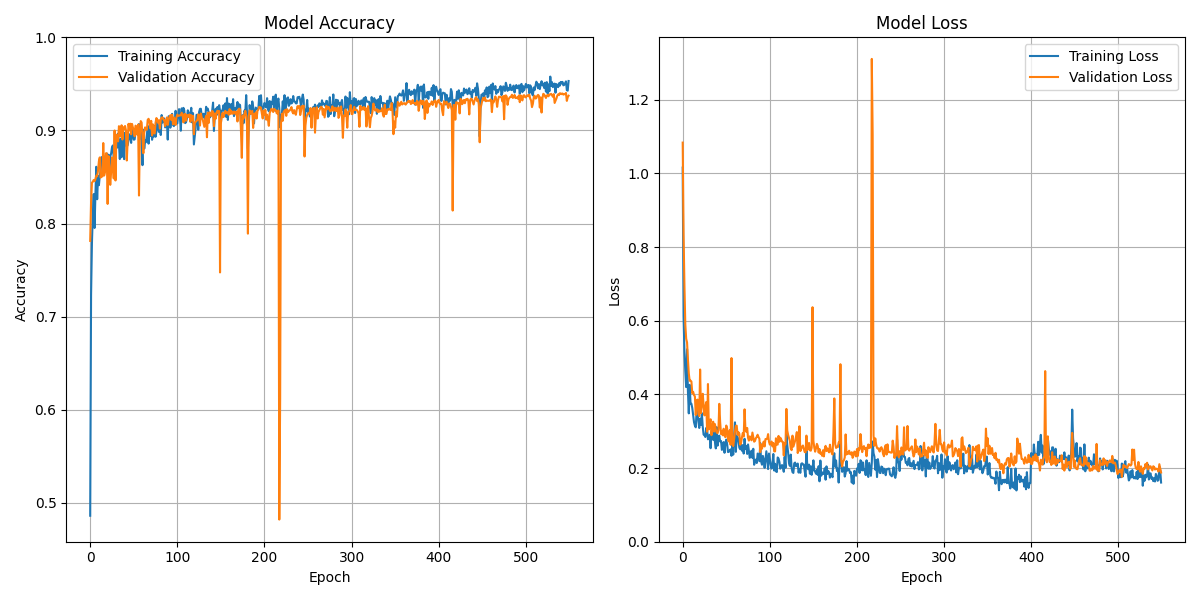

In [756]:
plot_history(history)

In [429]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 128, 128, 64)         640       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 128, 128, 64)         256       ['conv2d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_23 (Conv2D)          (None, 128, 128, 64)         36928     ['batch_normalization_18

In [767]:
#label = np.argmax(cloud_train, axis=-1)
#data = image_train

label = np.argmax(cloud_test, axis=-1)
data = image_test

# Predict on test data
predictions = model.predict(data)

diff = np.zeros(predictions.shape)

diff = np.argmax(predictions, axis=-1) - label
# prediction_threshold = 0.5

# predictions[predictions < prediction_threshold] = 0
# predictions[predictions >= prediction_threshold] = 1

2/2 [==============================] - 1s 199ms/step


33 46


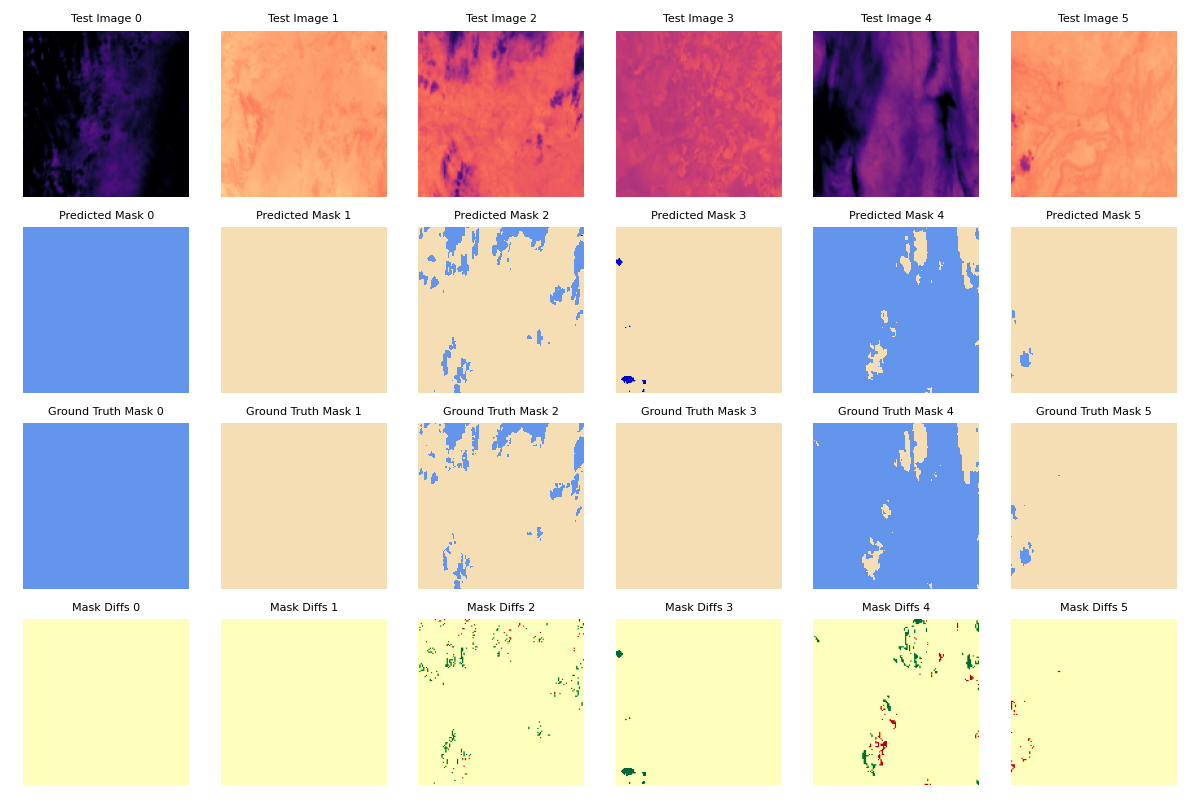

In [773]:
#label = np.argmax(cloud_test, axis=-1)
#data = image_test



cmap = mcolors.ListedColormap(['wheat', 'cornflowerblue', 'mediumblue', 'red'])



num_samples = 6

rand_offset = random.randint(0, data.shape[0]-num_samples-1)
#rand_offset = 0
print(rand_offset, data.shape[0])

# Plot a few samples  # You can change this number based on your preference

plt.figure(figsize=(12, 8))

for i in range(num_samples):
    # Original image (input)
    plt.subplot(4, num_samples, i + 1)
    plt.imshow(data[i + rand_offset, :, :], cmap='magma', vmin=-1, vmax=1)
    plt.title('Test Image ' + str(i), fontsize=8)
    plt.axis('off')

    # Predicted mask (output)
    plt.subplot(4, num_samples, i + 1 + num_samples)
    plt.imshow(np.argmax(predictions[i + rand_offset, :, :, :], axis=-1), cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Predicted Mask ' + str(i), fontsize=8)
    plt.axis('off')

    # True mask
    plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(label[i + rand_offset, :, :], cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Ground Truth Mask ' + str(i), fontsize=8)
    plt.axis('off')



    # diff[i + rand_offset, :, :, 0] = predictions[i + rand_offset, :, :, 0]-label[i + rand_offset, :, :, 0]

    # Diff mask
    plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
    plt.imshow(diff[i + rand_offset, :, :], cmap='RdYlGn', vmin=-1., vmax=1.) #RdBu''
    plt.title('Mask Diffs ' + str(i), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

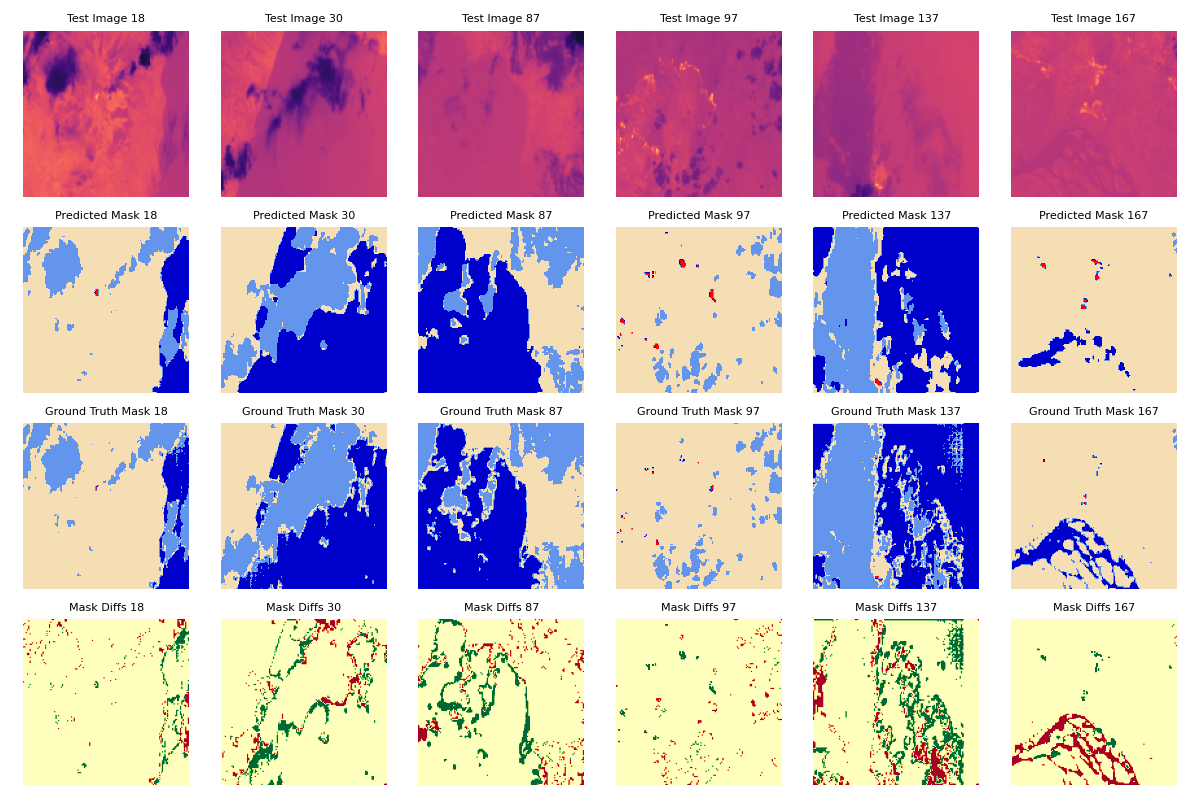

In [665]:
cmap = mcolors.ListedColormap(['wheat', 'cornflowerblue', 'mediumblue', 'red'])

# Define specific indexes to plot
indexes_to_plot = [18, 30, 87, 97, 137, 167]

# Number of samples is the length of indexes_to_plot
num_samples = len(indexes_to_plot)

plt.figure(figsize=(12, 8))

for idx, val in enumerate(indexes_to_plot):
    # Original image (input)
    plt.subplot(4, num_samples, idx + 1)
    plt.imshow(data[val, :, :], cmap='magma', vmin=-1, vmax=1)
    plt.title('Test Image ' + str(val), fontsize=8)
    plt.axis('off')

    # Predicted mask (output)
    plt.subplot(4, num_samples, idx + 1 + num_samples)
    plt.imshow(np.argmax(predictions[val, :, :, :], axis=-1), cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Predicted Mask ' + str(val), fontsize=8)
    plt.axis('off')

    # True mask
    plt.subplot(4, num_samples, idx + 1 + 2 * num_samples)
    plt.imshow(label[val, :, :], cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Ground Truth Mask ' + str(val), fontsize=8)
    plt.axis('off')

    # Diff mask
    plt.subplot(4, num_samples, idx + 1 + 3 * num_samples)
    plt.imshow(diff[val, :, :], cmap='RdYlGn', vmin=-1., vmax=1.)
    plt.title('Mask Diffs ' + str(val), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [577]:
top_threshold = 50
top_diff_index = np.argsort(np.array([abs(i.mean())+i.std() for i in diff]))[::-1][:top_threshold]
#top_diff_index = np.argsort(np.array([abs(i.mean()) for i in diff if i.mean() != 0]))[::-1][-top_threshold:]
#top_diff_index = np.argsort(np.array([i.mean() for i in diff]))[::-1][-top_threshold:]
top_diff_cut_frames = image_train[top_diff_index]
top_diff_cut_labels = cloud_train[top_diff_index]

In [730]:
single_frames = cut_frames[3:5]
prediction_single_frame = model.predict(single_frames)

1/1 [==============================] - 0s 105ms/step


(-0.5, 127.5, 127.5, -0.5)

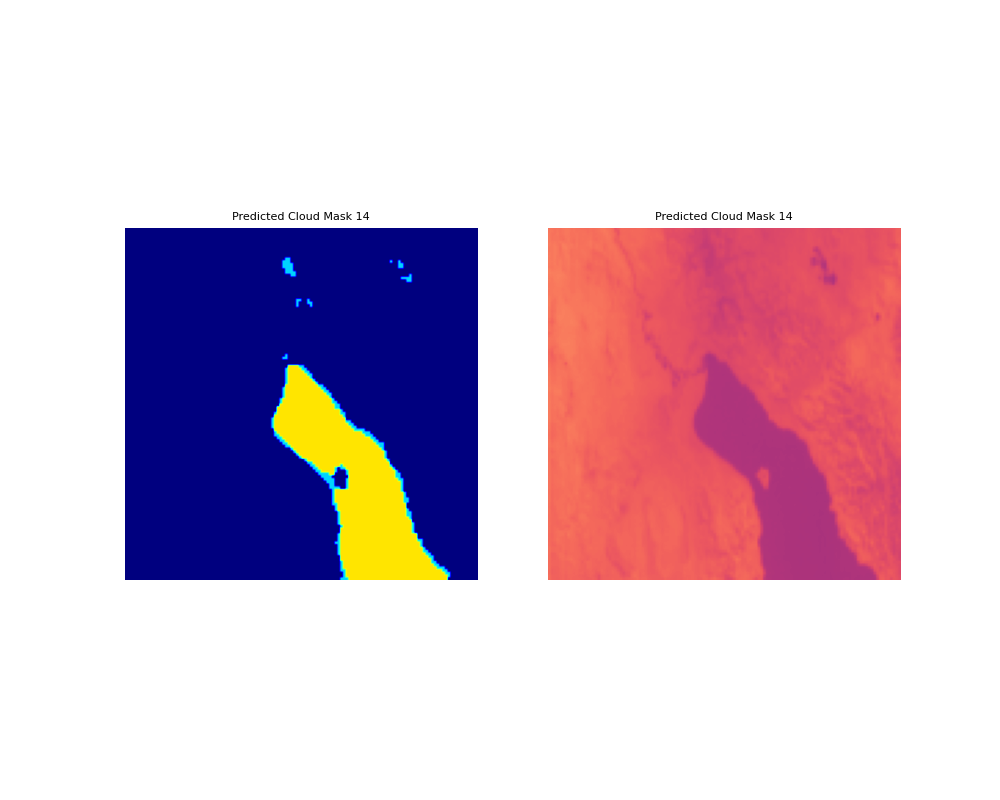

In [732]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(np.argmax(prediction_single_frame[0, :, :, :], axis=-1), cmap='jet', vmin=0.0, vmax=3)
plt.title('Predicted Cloud Mask ' + str(14), fontsize=8)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cut_frames[3], cmap='magma', vmin=-1, vmax=1)
plt.title('Predicted Cloud Mask ' + str(14), fontsize=8)
plt.axis('off')

In [692]:
model.save('best_IR_img2classmap_128x32_wc.keras')

In [766]:
model = models.load_model('best_IR_img2classmap_128x32_wc.keras')

In [295]:
#cloud_map_data[:,:,:,0].shape

# Initialize a variable to keep count of pixels for each class
class_counts = np.zeros(4)
total_counts = cloud_map_data.size/4#.shape[0]*cloud_map_data.shape[1]*cloud_map_data.shape[2]

# Sum the values in the last dimension to get the count for each class
class_counts = total_counts/np.sum(cloud_map_data, axis=(0, 1, 2))
class_counts_inv = total_counts/np.sum(cloud_map_data, axis=(0, 1, 2))
class_counts_inv = (class_counts_inv/np.min(class_counts_inv)).astype(int)

# Display the count for each class
for i, count in enumerate(class_counts_inv):
    print(f"Class {i}: {count}")

print(f"Total: {total_counts} pixels")

Class 0: 1
Class 1: 2
Class 2: 6
Class 3: 10197
Total: 3112960.0 pixels
